In [1]:
spark

In [1]:
dir0 = '/home/cloudera/2.kkbox_churn/data01/big_table_01/has-expired_auto-renew-0/last-1-week_has-record/'
infile = dir0 + '02a.numeric_transformed'

df0 = spark.read.format('parquet').load(infile)

In [2]:
df0.printSchema()

root
 |-- msno: string (nullable = true)
 |-- city: string (nullable = true)
 |-- registered_via: string (nullable = true)
 |-- has_long_gap: boolean (nullable = true)
 |-- last_pay_method: string (nullable = true)
 |-- pay_method_mode: string (nullable = true)
 |-- is_churn: boolean (nullable = true)
 |-- days_since_init_regist_log: double (nullable = true)
 |-- total_gap_len: integer (nullable = true)
 |-- last_list_price: integer (nullable = true)
 |-- last_paid_per_day: double (nullable = true)
 |-- actual_paid_cnt_uniq: integer (nullable = true)
 |-- last1WeekOnLine: integer (nullable = true)
 |-- last1WeekOnLine_D_last12WeekOnLine_log: double (nullable = true)
 |-- w1_M75_sqrt: double (nullable = true)
 |-- w12_M75_sqrt: double (nullable = true)
 |-- w1_M985_sqrt: double (nullable = true)
 |-- w1_Mtotal_log: double (nullable = true)
 |-- w1_Mtotal_D_w12_Mtotal_log: double (nullable = true)
 |-- w1_M25_D_Mtotal_sqrt: double (nullable = true)
 |-- w1_M50_D_Mtotal_sqrt: double (null

In [3]:
cols_categorical = [
 'city',
 'registered_via',
 'has_long_gap',
 'last_pay_method',
 'pay_method_mode',
]

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import math

def plot_categorical_value_counts(df, cols, nFigCols):
    ''' Return fig '''
    nFigRows = int(math.ceil(len(cols)/nFigCols))
    fig = plt.figure()
    for i in range(len(cols)):
        ax = fig.add_subplot(nFigRows, nFigCols, i+1)

        values = pd.Series(df0.rdd.map(lambda row: row[cols[i]]).collect())
        value_freqs = values.value_counts().sort_index()

        value_freqs.plot.bar(ax=ax, color='#2277cc')
        ax.set(title=cols[i], ylabel='count')

        fig.subplots_adjust(wspace=0.3, hspace=0.55)
    return fig

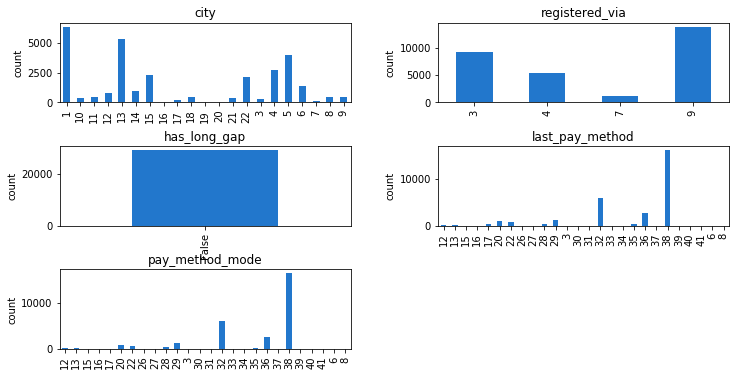

In [46]:
fig = plot_categorical_value_counts(df0, cols_categorical, 2)
fig.set_size_inches(12, 6)
plt.show()

# transform

In [4]:
# city
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def group_cities(city):
    if '10' <= city <= '12':
        return '10-12'
    elif '16' <= city <= '21':
        return '16-21'
    elif city == '3' or '7' <= city <= '9':
        return '03/07-09'
    else :
        return city.zfill(2)

udf_group_cities = udf(group_cities, StringType())    

df0 = df0.withColumnRenamed('city', 'city_orig') \
      .withColumn('city', udf_group_cities('city_orig')) \
      .drop('city_orig')

In [5]:
# last_pay_method
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def group_pay_method(pay_method):
    if pay_method in ['32', '36', '38']:
        return pay_method
    else:
        return 'other'

udf_group_pay_method = udf(group_pay_method, StringType())    

df0 = df0.withColumnRenamed('last_pay_method', 'last_pay_method_orig') \
      .withColumn('last_pay_method', udf_group_pay_method('last_pay_method_orig')) \
      .drop('last_pay_method_orig')

In [6]:
# pay_method_mode
df0 = df0.withColumnRenamed('pay_method_mode', 'pay_method_mode_orig') \
      .withColumn('pay_method_mode', udf_group_pay_method('pay_method_mode_orig')) \
      .drop('pay_method_mode_orig')

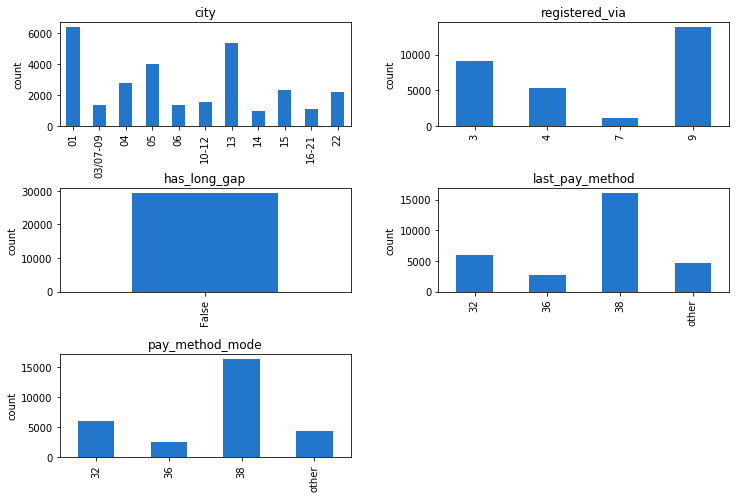

In [9]:
fig = plot_categorical_value_counts(df0, cols_categorical, 2)
fig.set_size_inches(12, 8)
fig.subplots_adjust(hspace=0.6)
plt.show()

# select

In [7]:
cols_categ_select1 = [
 'city',
 'registered_via',
 #'has_long_gap',    # all = false
 'last_pay_method',
 'pay_method_mode',
]

In [16]:
df0.select(cols_categ_select1).show(10)

+--------+--------------+---------------+---------------+
|    city|registered_via|last_pay_method|pay_method_mode|
+--------+--------------+---------------+---------------+
|      05|             9|             32|             32|
|   16-21|             9|             32|             32|
|      01|             7|             38|             38|
|      01|             9|             38|             38|
|      04|             9|             38|             38|
|03/07-09|             9|          other|          other|
|      05|             3|             38|             38|
|      01|             4|             36|             36|
|      01|             4|             38|             38|
|      05|             4|             38|             38|
+--------+--------------+---------------+---------------+
only showing top 10 rows



In [17]:
df0.crosstab('last_pay_method', 'pay_method_mode') \
   .sort('last_pay_method_pay_method_mode').show()

+-------------------------------+----+----+-----+-----+
|last_pay_method_pay_method_mode|  32|  36|   38|other|
+-------------------------------+----+----+-----+-----+
|                             32|5945|   0|    0|    0|
|                             36|  79|2471|  140|   49|
|                             38|  20|  57|15866|  132|
|                          other|  34|  16|  378| 4180|
+-------------------------------+----+----+-----+-----+



In [18]:
df0.crosstab('last_pay_method', 'registered_via').show()

+------------------------------+----+----+---+----+
|last_pay_method_registered_via|   3|   4|  7|   9|
+------------------------------+----+----+---+----+
|                            36| 908| 495|145|1191|
|                            38|5393|3435|408|6839|
|                            32|1336| 395|402|3812|
|                         other|1488|1032|129|1959|
+------------------------------+----+----+---+----+



In [19]:
df0.crosstab('city', 'registered_via').show()

+-------------------+----+----+---+----+
|city_registered_via|   3|   4|  7|   9|
+-------------------+----+----+---+----+
|           03/07-09| 471| 169| 58| 630|
|                 15| 779| 299| 83|1171|
|                 22| 743| 316| 68|1053|
|                 13|1529| 530|221|3079|
|                 05|1371| 561|134|1956|
|                 04| 919| 424|112|1300|
|              10-12| 548| 205| 48| 777|
|                 06| 469| 209| 31| 637|
|                 14| 313| 114| 50| 503|
|              16-21| 392| 164| 33| 516|
|                 01|1591|2366|246|2179|
+-------------------+----+----+---+----+



In [8]:
cols_categ_select2 = [
 'city',
 'registered_via',
 #'has_long_gap',    # all = false
 'last_pay_method',
 #'pay_method_mode',   # correlated with last_pay_method
]

cols_to_drop = list(set(cols_categorical) - set(cols_categ_select2))
df = df0.drop(*cols_to_drop)

# move categorical fields to the end
cols_other = list(set(df.columns) - set(cols_categ_select2) - set(('msno', 'is_churn')))
df1 = df.select('msno', *(cols_other + cols_categ_select2), 'is_churn')

df1.printSchema()

root
 |-- msno: string (nullable = true)
 |-- last_paid_per_day: double (nullable = true)
 |-- w12_M50_D_Mtotal_sqrt: double (nullable = true)
 |-- w1_M75_sqrt: double (nullable = true)
 |-- days_since_init_regist_log: double (nullable = true)
 |-- w1_Mtotal_D_w12_Mtotal_log: double (nullable = true)
 |-- w1_M50_D_Mtotal_sqrt: double (nullable = true)
 |-- last1WeekOnLine: integer (nullable = true)
 |-- total_gap_len: integer (nullable = true)
 |-- actual_paid_cnt_uniq: integer (nullable = true)
 |-- last_list_price: integer (nullable = true)
 |-- w12_M75_sqrt: double (nullable = true)
 |-- w1_M985_sqrt: double (nullable = true)
 |-- w1_M25_D_Mtotal_sqrt: double (nullable = true)
 |-- w1_Munq_D_Mtotal_sqrt: double (nullable = true)
 |-- w1_Mtotal_log: double (nullable = true)
 |-- last1WeekOnLine_D_last12WeekOnLine_log: double (nullable = true)
 |-- city: string (nullable = true)
 |-- registered_via: string (nullable = true)
 |-- last_pay_method: string (nullable = true)
 |-- is_churn:

In [9]:
# output

#outfile = dir0 + '03a.numer-transformed_categ-transformed'
#df1.write.format('parquet').save(outfile)

outfile = dir0 + '03a.numer-transformed_categ-transformed.csv'
df1.coalesce(1).write.format('csv').option('header', 'true').save(outfile)